# Problem 2: Structured Light

**Notational conventions**

* Any variable followed by "_p" is in the reference frame of the projector
* Any variable followed by "_c" is in the reference frame of the camera
* Any variable followed by "_img" is an HxWxC image
* Often we will use vectorized versions of the images, which are (HxW)xC dimensional arrays. Typically we will use N=HxW, so the size is NxC

* xy refers to original image coordinates
* uv refers to shifted image coordinates
* XYZ refers to world coordinates

Examples:
* XYZ_p is an Nx3 array of N points in projector world coordinates, that is, world coordinates with a reference frame centered on the projector.

* rgb_c_img is an HxWxC array of observed rgb values from the camera's perspective (i.e. it's just the photo taken by the camera!)

In [1]:
# Download util.py and data
import requests
import os

def download(url, fn):
    r = requests.get(url)
    if r.status_code == 200:
        open(fn, 'wb').write(r.content)
        print("{} downloaded: {:.2f} KB".format(fn, len(r.content)/1024.))
    else:
        print("url not found:", url)

print("Download util.py and data (it may take ~40 seconds on google colab)")

# download util.py
download('http://6.869.csail.mit.edu/sp22/pset2_data/util.py', 'util.py')

# download data 
os.makedirs('Motorcycle-perfect', exist_ok=True)
download('http://6.869.csail.mit.edu/sp22/pset2_data/Motorcycle-perfect/rgb_camera_view.png', 'Motorcycle-perfect/rgb_camera_view.png')
download('http://6.869.csail.mit.edu/sp22/pset2_data/Motorcycle-perfect/stripe_lights.png', 'Motorcycle-perfect/stripe_lights.png')
download('http://6.869.csail.mit.edu/sp22/pset2_data/Motorcycle-perfect/z_camera_view.mat', 'Motorcycle-perfect/z_camera_view.mat')
download('http://6.869.csail.mit.edu/sp22/pset2_data/Motorcycle-perfect/z_projector_view.mat', 'Motorcycle-perfect/z_projector_view.mat')

Download util.py and data (it may take ~40 seconds on google colab)
util.py downloaded: 5.99 KB
Motorcycle-perfect/rgb_camera_view.png downloaded: 7018.61 KB
Motorcycle-perfect/stripe_lights.png downloaded: 1.09 KB
Motorcycle-perfect/z_camera_view.mat downloaded: 39729.57 KB
Motorcycle-perfect/z_projector_view.mat downloaded: 39838.49 KB


In [2]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np
import cv2
import util

# flatten to Nx1
def flatten(x):
    return x.reshape([-1, 1])

# show color & depth image
def imshow(img, ax=plt, cmap=None):
    if len(img.shape) == 3:
        # display color image
        img_RGB = img[:,:,::-1] # convert BGR to RGB
        img_RGB[np.isnan(img_RGB)] = img_RGB[~np.isnan(img_RGB)].min() # visualize nan as the minimal color
        axis_image = ax.imshow(img_RGB, cmap=cmap)
    else:
        # display depth image
        img_depth = img.copy()
        img_depth[np.isnan(img_depth)] = img_depth[~np.isnan(img_depth)].min() # visualize nan as the minimal depth
        axis_image = ax.imshow(img_depth, cmap=cmap)
    
    return axis_image


# animate image sequences for ipython notebook & google colab
class AnimationWrapper():
    def __init__(self, rows, cols, frames, figsize=(8, 6)):
        self.rows, self.cols = rows, cols
        self.frames = frames
        
        self.fig = plt.figure(figsize=figsize)
        self.axes = []
        self.axis_images = []
        self.data = []
        for r in range(rows):
            for c in range(cols):
                ax = plt.subplot(rows, cols, r * cols + c + 1)
                img = imshow(frames[0][r * cols + c], ax=ax)
                
                self.axes.append(ax)
                self.axis_images.append(img)
                self.data.append([])
        plt.close()
        
        # Set maximal limit to 100 MB, default is 20 MB
        matplotlib.rcParams['animation.embed_limit'] = 100
    
    def get_axes(self):
        return self.axes
    
    def animate(self, i):
        if i % 10 == 0:
            print("laser scanning... {} / {}".format(i+1,len(self.frames)))
        for ax_id in range(len(self.axis_images)):
            frame = self.frames[i][ax_id]
            if len(frame.shape) == 3:
                self.axis_images[ax_id].set_data(frame[:,:,::-1])
            else:
                depth = frame.copy()
                depth[np.isnan(depth)] = depth[~np.isnan(depth)].min()
                self.axis_images[ax_id].set_data(depth)
                self.axis_images[ax_id].set_clim(depth.min(), depth.max())
        return tuple(self.axis_images)
    
    def generate(self):
        self.anim = animation.FuncAnimation(self.fig, self.animate, frames=len(self.frames), interval=100, blit=True)
        
        # Note: below is the part which makes it work on Colab
        rc('animation', html='jshtml')

ModuleNotFoundError: No module named 'cv2'

In [4]:
% pip3 install cv2

UsageError: Line magic function `%` not found.


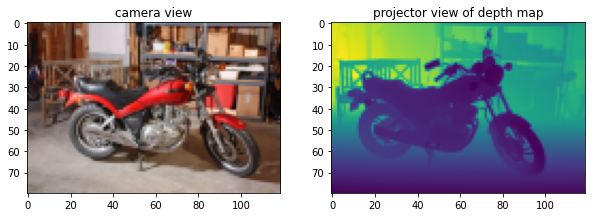

In [ ]:
# load images
scale = 0.04 # for the first experiment, we will use small images
Z_p_img, Z_c_img, rgb_c_img, f, d, cx_c, cy_c, cx_p, cy_p, img_size = util.load_images_and_params(scale)

plt.figure(figsize=(10, 20))
plt.subplot(121); imshow(rgb_c_img); plt.title('camera view');
plt.subplot(122); imshow(Z_p_img); plt.title('projector view of depth map');

### (b) Camera image coordinates

Fill in the lines marked ## TODO

In [ ]:
def getTransformationMatrices(f, d):
    """
    map (u_p,v_p,1/Z_p) to (X_p,Y_p,Z_p)
    
    note that 1/Z_p here is not the Z coordinate for (u_p, v_p). it is 
    only for math convenience. hint: derive the equation for (X_p, Y_p, Z_p)
    using u_p, v_p, Z_p, f, d; then find the equivalent T1

    note that if the homogeneous coordinates of a point are multiplied
    by a non-zero scalar, a, then the resulting coordinates represent the
    same point.
    | ? ? ? ? | | u |   | aX|                                 |X|
    | ? ? ? ? |*| v | = | aY|, which represents same point as |Y|
    | ? ? ? ? | |1/z|   | aZ|                                 |Z|
    | ? ? ? ? | | 1 |   | a |                                 |1|
    """
    T1 = ## TODO

    """
    map (X_p,Y_p,Z_p) to (X_c,Y_c,Z_c)
     
    | ? ? ? ? | | X_p |   | X_c |
    | ? ? ? ? |*| Y_p | = | Y_c |
    | ? ? ? ? | | Z_p |   | Z_c |
    | ? ? ? ? | |  1  |   |  1  | 
    """
    T2 = ## TODO

    """
     map (X_c,Y_c,Z_c) to (u_c,v_c)
     
    | ? ? ? ? | | X |   | au |                                 |u|
    | ? ? ? ? |*| Y | = | av |, which represents same point as |v|
    | ? ? ? ? | | Z |   |  a |                                 |1|
                | 1 |
    """
    T3 = ## TODO

      
    # map (u_p,v_p,1/Z_p) to (u_c,v_c)
    T = ## TODO
    
    return T, T1, T2, T3

T, T1, T2, T3 = getTransformationMatrices(f,d)

In [ ]:
def transform_xy_p_to_uv_p(xy_p, cx_p, cy_p):
    # xy_p is Nx2
    # cx_p, cy_p are the principal point coordinates for the projector
    
    center_p = np.matlib.repmat([cx_p, cy_p], xy_p.shape[0], 1)
    return xy_p - center_p

def transform_uv_c_to_xy_c(uv_c, cx_c, cy_c):
    # uv_c is Nx2
    # cx_c, cy_c are the principal point coordinates for the camera
    
    center_c = np.matlib.repmat([cx_c, cy_c], uv_c.shape[0], 1)
    return uv_c + center_c

def transform_xy_c_to_uv_c(xy_c, cx_c, cy_c):
    # xy_c is Nx2
    # cx_c, cy_c are the principal point coordinates for the camera
    
    center_c = np.matlib.repmat([cx_c, cy_c], xy_c.shape[0], 1)
    return xy_c - center_c

def transform_xy_p_to_xy_c(xy_p, Z, cx_p, cy_p, cx_c, cy_c, T):
    # xy_p is Nx2
    # Z is Nx1
    # cx_p, cy_p are the principal point coordinates for the projector
    # cx_c, cy_c are the principal point coordinates for the camera
    # T is transformation matrix from uv_p to uv_c
    
    uv_p = transform_xy_p_to_uv_p(xy_p, cx_p, cy_p)
    uv_c = util.transform_uv_p_to_uv_c(uv_p, Z, T)
    xy_c = transform_uv_c_to_xy_c(uv_c, cx_c, cy_c)
    return xy_c


### (c) Laser scan of a scene
We provide the code to scan the scene from top to bottom. To answer the questions in the problem set, you will need to adjust it to scan from left to right.

* Run the code & watch the scanning video (you could verify your results with the [reference video](https://drive.google.com/file/d/1ZyW92QmCK-SRx7SZS3Ozf68tK18RhcsQ/view?usp=sharing))

* Uncomment the lines with ## TODO to change the scanning direction. Does the laser still wiggle?

In [ ]:
def draw_square(img, x, y, r=1):
    cv2.rectangle(img, (x-r, y-r), (x+r, y+r), (0, 0, 255), -1)
    
frames = [] # for animation

width = Z_p_img.shape[1]
height = Z_p_img.shape[0]

for x_p in range(1, width, 20): # iterating across pixels in the projector's virtual image plane
    for y_p in range(1, height, 4): # and in the other direction
                                    # starting from 1 for better visualization on the boundary
        
# for y_p in range(1, height, 20): ## TODO: uncomment the line to scan from left to right
#     for x_p in range(1, width, 4): ## TODO: uncomment the line to scan from left to right
        
        # get query coordinates in projector's image
        xy_p = np.array([[x_p, y_p]])
        
        # transform xy_p to uv_p
        uv_p = transform_xy_p_to_uv_p(xy_p, cx_p, cy_p)

        # transform to corresponding coordinates in camera's image
        uv_c = util.transform_uv_p_to_uv_c(uv_p, np.array([[Z_p_img[y_p, x_p]]]), T)
        
        # transform uv_c to xy_c
        xy_c = transform_uv_c_to_xy_c(uv_c, cx_c, cy_c)

        # laser illuminates {u_c,v_c} in camera's image, so let's render this
        rgb_c_img_one_laser = np.zeros_like(rgb_c_img)
        x_c, y_c = int(round(xy_c[0, 0])), int(round(xy_c[0, 1]))
        if x_c >= 0 and x_c < rgb_c_img.shape[1] and y_c >= 0 and y_c < rgb_c_img.shape[0]:
            draw_square(rgb_c_img_one_laser, x_c, y_c)
        
        # let's also render where the laser lands from the projector's view
        # (it should just do a raster scan of the image!)
        rgb_p_img_one_laser = np.zeros_like(rgb_c_img)
        draw_square(rgb_p_img_one_laser, x_p, y_p)
        
        frames.append([rgb_c_img, Z_p_img, rgb_c_img_one_laser, rgb_p_img_one_laser])
        

animate_wrapper = AnimationWrapper(rows=2, cols=2, frames=frames)

axes = animate_wrapper.get_axes()
axes[0].set_title("camera view with lights on")
axes[1].set_title("projector view of depth map")
axes[2].set_title("camera view in the dark")
axes[3].set_title("projector view in the dark")

animate_wrapper.generate()
animate_wrapper.anim

### (d) Inferring camera depth
Fill in the line marked ## TODO

In [ ]:
# estimate depth, Z_c, from camera's view, for the point at pixel uv_c, in
# camera's image frame, using the fact that we know uv_p also corresponds
# to this world point


def inferDepthFromMatchedCoords(uv_c, uv_p, f, d):
# uv_p and uv_c are Nx2 arrays of N points with 2 coordinates (u and v) each
# Z_c should be a Nx1 array

    Z_c = ## TODO
    return Z_c

In [ ]:
frames = [] # for animation

Z_c_img_estimated = np.zeros_like(Z_p_img) * np.nan # nan for unknown depth

width = Z_p_img.shape[1]
height = Z_p_img.shape[0]


for x_p in range(width): # iterating across pixels in the projector's virtual image plane
    for y_p in range(height): # and in the other direction
        
        # get query coordinates in projector's image
        xy_p = np.array([[x_p, y_p]])
        
        # transform xy_p to uv_p
        uv_p = transform_xy_p_to_uv_p(xy_p, cx_p, cy_p)
        
        # transform to corresponding coordinates in camera's image
        uv_c = util.transform_uv_p_to_uv_c(uv_p, np.array([[Z_p_img[y_p, x_p]]]), T)

        # transform uv_c to xy_c
        xy_c = transform_uv_c_to_xy_c(uv_c, cx_c, cy_c)

        # laser illuminates {u_c,v_c} in camera's image, so let's render this
        rgb_c_img_one_laser = np.zeros_like(rgb_c_img)
        
        x_c, y_c = int(round(xy_c[0, 0])), int(round(xy_c[0, 1]))
        
        # skip if the projected pixel is out of boundary
        if x_c < 0 or x_c >= rgb_c_img.shape[1] or y_c < 0 or y_c >= rgb_c_img.shape[0]:
            continue
        
        draw_square(rgb_c_img_one_laser, x_c, y_c)
        
        # We know that this illuminated point corresponds to projected 
        # pixel {u_p,v_p}, so we can triangulate to get the depth
        Z_c_img_estimated[y_c, x_c] = inferDepthFromMatchedCoords(uv_c, uv_p, f, d)
        
        # let's also render where the laser lands from the projector's view
        # (it should just do a raster scan of the image!)
        rgb_p_img_one_laser = np.zeros_like(rgb_c_img)
        draw_square(rgb_p_img_one_laser, x_p, y_p)

        frames.append([rgb_c_img, Z_c_img_estimated.copy(), rgb_c_img_one_laser, rgb_p_img_one_laser])

plt.figure(figsize=(10, 20))
plt.subplot(121); imshow(rgb_c_img); plt.title('camera view with lights on');
plt.subplot(122); imshow(Z_c_img_estimated); plt.title('camera view of inferred depth');

In [ ]:
# Optional: we can also visualize the inferred depth during the scanning process

stride = 90 # skip frames for faster visualization; 
animate_wrapper = AnimationWrapper(rows=2, cols=2, frames=frames[::stride])

axes = animate_wrapper.get_axes()
axes[0].set_title("camera view with lights on")
axes[1].set_title("camera view of inferred depth")
axes[2].set_title("camera view in the dark")
axes[3].set_title("projector view in the dark")

animate_wrapper.generate()
animate_wrapper.anim

### (e) Projecting structured light

Complete the lines marked ## TODO

In [ ]:
# first load the images at a larger size
scale = 0.2 # for the first experiment, we will use small images
Z_p_img, Z_c_img, rgb_c_img, f, d, cx_c, cy_c, cx_p, cy_p, img_size = util.load_images_and_params(scale)

# get T again since it depends on f, which changed scale
T, T1, T2, T3 = getTransformationMatrices(f, d)

plt.figure(figsize=(10, 20))
plt.subplot(121); imshow(rgb_c_img); plt.title('camera view');
plt.subplot(122); imshow(Z_p_img); plt.title('projector view of depth map');

In [ ]:
def getImgCoordinatePairs(Z_p_img, T, img_size, cx_p, cy_p, cx_c, cy_c):
    # Z_p_img is HxW
    # T is the transformation matrix from uv_p to uv_c
    # img_size is a tuple(H, W); e.g. img_size = (400, 593) in this case

    # xy_c should be Nx2
    # xy_p should be Nx2

    # hint: try using np.meshgrid to create xy_p, then transform to xy_c using
    #       transform_xy_p_to_xy_c as shown in previous code
    xy_p = ## TODO
    xy_c = ## TODO
    
    return xy_c, xy_p

In [ ]:
# get structured light to be projected
L_p_img = cv2.resize(np.mean(cv2.imread('./Motorcycle-perfect/stripe_lights.png').astype(np.float32), 2), (img_size[1], img_size[0]))

# render illuminated image seen by camera, L_c_img
[xy_c, xy_p] = getImgCoordinatePairs(Z_p_img, T, img_size, cx_p, cy_p, cx_c, cy_c)

Z_c = flatten(Z_c_img) # to handle occlusion during rendering, we need the depth map from the
                       # camera's perspective

L_c_img = util.render(xy_c, xy_p, Z_c, L_p_img)
L_c_img[np.isnan(L_c_img)] = 0.

plt.figure(figsize=(10, 20))
plt.subplot(121); imshow(L_c_img / 255., cmap='gray'); plt.title('camera view of light pattern illuminating scene');
plt.subplot(122); imshow(((np.dstack([L_c_img, L_c_img, L_c_img]) + rgb_c_img) / 255.) / 2); plt.title('light pattern overlaid on rgb');

### (f) Inferring depth from structured light

Complete the lines marked ## TODO

In [ ]:
def getStructuredLight(img_size):
    # img_size is a tuple(H, W); e.g. img_size = (400, 593) in this case

    # L_p_img should be the same shape as the image, and specifies the intensity
    # to project at each pixel, with dimention HxW

    # Hint: we want to project a pattern of light such that a simple function
    # of each pixel intensity (or patch) tells us the x_p coordinate.

    # Hint: we can assume the renderer is ideal without noises, i.e. the projected 
    # image can be measured accurately by the camera.

    L_p_img = ## TODO
    return L_p_img

def F(L_c, xy_c):
    # L_c is Nx1
    # xy_c is Nx2
    # xy_p should be Nx2

    xy_p = ## TODO
    return xy_p

In [ ]:
# render L_c_img
L_p_img = getStructuredLight(img_size)

xy_c, xy_p = getImgCoordinatePairs(Z_p_img, T, img_size, cx_p, cy_p, cx_c, cy_c)
Z_c = flatten(Z_c_img)

L_c_img = util.render(xy_c, xy_p, Z_c, L_p_img)

# infer depth only using L_c_img
x_c_img, y_c_img = np.meshgrid(np.arange(img_size[1]), np.arange(img_size[0]))
xy_c = np.hstack([flatten(x_c_img), flatten(y_c_img)])

xy_p_decoded = F(flatten(L_c_img), xy_c) # this refers to the decoded xy_p[i] corresponding to xy_c[i]

uv_p_decoded = transform_xy_p_to_uv_p(xy_p_decoded, cx_p, cy_p)
uv_c = transform_xy_c_to_uv_c(xy_c, cx_c, cy_c)
Z_c_inferred = inferDepthFromMatchedCoords(uv_c, uv_p_decoded, f, d)
Z_c_inferred_img = np.reshape(Z_c_inferred, img_size)

plt.figure(figsize=(10, 20))
plt.subplot(121); imshow(L_c_img, cmap="gray"); plt.title('camera view of light pattern illuminating scene');
plt.subplot(122); imshow(Z_c_inferred_img); plt.title('inferred depth');

### (g) *6.869 only*: Lambertian rendering

Complete the lines marked ## TODO

In [ ]:
# hint: try projecting a color image

def getStructuredLight_Lambertian(img_size):
    # img_size is tuple(H, W); e.g. img_size = (400, 593) in this case
    # L_p_img should be HxWx3

    L_p_img = ## TODO
    return L_p_img

def F_Lambertian(L_c, xy_c):
    # L_c is Nx3
    # xy_c is Nx2
    # xy_p should be Nx2

    xy_p = ## TODO
    return xy_p

In [ ]:
# get structured light to be projected
L_p_img = getStructuredLight_Lambertian(img_size)

# render L_c_img
xy_c, xy_p = getImgCoordinatePairs(Z_p_img, T, img_size, cx_p, cy_p, cx_c, cy_c)
Z_c = flatten(Z_c_img)

uv_p = transform_xy_p_to_uv_p(xy_p, cx_p, cy_p)
XYZ_p = util.transform_uv_p_to_XYZ_p(uv_p, flatten(Z_p_img), T1)
L_c_img = util.render_Lambertian(xy_c, xy_p, Z_c, XYZ_p, L_p_img)

# infer depth only using L_c_img
x_c_img, y_c_img = np.meshgrid(np.arange(img_size[1]), np.arange(img_size[0]))
xy_c = np.hstack([flatten(x_c_img), flatten(y_c_img)])

L_c = np.reshape(L_c_img, [img_size[1]*img_size[0], L_c_img.shape[2]])
xy_p_decoded = F_Lambertian(L_c, xy_c)

uv_p_decoded = transform_xy_p_to_uv_p(xy_p_decoded, cx_p, cy_p)
uv_c = transform_xy_c_to_uv_c(xy_c, cx_c, cy_c)
Z_c_inferred = inferDepthFromMatchedCoords(uv_c, uv_p_decoded, f, d)
Z_c_inferred_img = np.reshape(Z_c_inferred, img_size)

plt.figure(figsize=(10, 20))
plt.subplot(121); imshow(L_c_img / L_c_img[~np.isnan(L_c_img)].max()); plt.title('camera view of light pattern illuminating scene');
plt.subplot(122); imshow(Z_c_inferred_img); plt.title('inferred depth');